In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import random
import os


In [2]:
from sklearn.linear_model import RANSACRegressor, LinearRegression

def spike_detection_nd(points, max_hyperplanes=30, min_points_for_hyperplane=100, residual_threshold=0.5, merge_threshold=0.01):
    residual_threshold *= (points.shape[1] - 1)
    
    def fit_hyperplane_ransac(points):
        n_dims = points.shape[1]
        dependent_dim = np.random.randint(n_dims)
        
        X = np.delete(points, dependent_dim, axis=1)
        y = points[:, dependent_dim]
        
        ransac = RANSACRegressor(LinearRegression(), 
                                 max_trials=1000, 
                                 min_samples=n_dims,
                                 residual_threshold=residual_threshold,
                                 stop_probability=0.99)
        ransac.fit(X, y)
        return ransac, dependent_dim
    
    def get_hyperplane_eq(ransac, dependent_dim, n_dims):
        coef = ransac.estimator_.coef_
        intercept = ransac.estimator_.intercept_
        
        full_coef = np.zeros(n_dims)
        full_coef[:dependent_dim] = coef[:dependent_dim]
        full_coef[dependent_dim+1:] = coef[dependent_dim:]
        full_coef[dependent_dim] = -1
        
        return full_coef, intercept
    
    def point_to_hyperplane_distance(point, coef, intercept):
        return np.abs(np.dot(coef, point) + intercept) / np.linalg.norm(coef)
    
    def hyperplane_distance(coef1, intercept1, coef2, intercept2):
        cos_angle = np.dot(coef1, coef2) / (np.linalg.norm(coef1) * np.linalg.norm(coef2))
        angle = np.arccos(np.clip(cos_angle, -1.0, 1.0))
        d = np.abs(intercept1 - intercept2) / np.linalg.norm(coef1)
        return angle, d
    
    n_dims = points.shape[1]
    hyperplanes = []
    remaining_points = points.copy()
    assigned_points = []
    total_error = 0
    
    for _ in tqdm(range(max_hyperplanes), desc="Fitting Hyperplanes"):
        if len(remaining_points) < min_points_for_hyperplane:
            break
        
        try:
            ransac, dependent_dim = fit_hyperplane_ransac(remaining_points)
        except:
            break
        
        coef, intercept = get_hyperplane_eq(ransac, dependent_dim, n_dims)
        
        inlier_mask = ransac.inlier_mask_
        inlier_points = remaining_points[inlier_mask]
        
        hyperplane_error = sum(point_to_hyperplane_distance(p, coef, intercept) for p in inlier_points)
        total_error += hyperplane_error
        
        hyperplanes.append((coef, intercept, len(inlier_points), hyperplane_error))
        assigned_points.append(inlier_points)
        
        remaining_points = remaining_points[~inlier_mask]
    
    if len(hyperplanes) == 0:
        return [], 0, []
    
    # Assign remaining points to the nearest hyperplane
    for point in remaining_points:
        distances = [point_to_hyperplane_distance(point, coef, intercept) for coef, intercept, _, _ in hyperplanes]
        nearest_hyperplane_index = np.argmin(distances)
        total_error += distances[nearest_hyperplane_index]
        assigned_points[nearest_hyperplane_index] = np.vstack([assigned_points[nearest_hyperplane_index], point])
    
    # Merge close hyperplanes
    i = 0
    while i < len(hyperplanes):
        j = i + 1
        while j < len(hyperplanes):
            angle, dist = hyperplane_distance(hyperplanes[i][0], hyperplanes[i][1], hyperplanes[j][0], hyperplanes[j][1])
            if angle < merge_threshold:
                # Merge hyperplanes
                new_coef = (hyperplanes[i][0] + hyperplanes[j][0]) / 2
                new_intercept = (hyperplanes[i][1] + hyperplanes[j][1]) / 2
                new_inliers = hyperplanes[i][2] + hyperplanes[j][2]
                new_error = hyperplanes[i][3] + hyperplanes[j][3]
                new_points = np.vstack([assigned_points[i], assigned_points[j]])
                
                hyperplanes[i] = (new_coef, new_intercept, new_inliers, new_error)
                assigned_points[i] = new_points
                
                # Remove the merged hyperplane
                del hyperplanes[j]
                del assigned_points[j]
            else:
                j += 1
        i += 1
    
    # Sort hyperplanes by number of inliers (descending)
    if hyperplanes:
        hyperplanes, assigned_points = zip(*sorted(zip(hyperplanes, assigned_points), key=lambda x: x[0][2], reverse=True))
    else:
        hyperplanes, assigned_points = [], []
    
    return hyperplanes, total_error, assigned_points


In [3]:
def generate_high_dimensional_data(num_points=1000, n_dims=100, num_clusters=5, cluster_spread=1.0):
    """
    Generate synthetic high-dimensional data clustered around multiple hyperplanes.
    
    Args:
        num_points (int): Total number of data points.
        n_dims (int): Number of dimensions.
        num_clusters (int): Number of hyperplane clusters.
        cluster_spread (float): Standard deviation of clusters around hyperplanes.
    
    Returns:
        np.ndarray: Generated data points of shape (num_points, n_dims).
    """
    points_per_cluster = num_points // num_clusters
    data = []
    
    for _ in range(num_clusters):
        # Randomly generate a hyperplane
        coef = np.random.randn(n_dims)
        coef /= np.linalg.norm(coef)  # Normalize
        intercept = np.random.uniform(-5, 5)
        
        # Generate points around the hyperplane
        # Choose a random dependent dimension for each hyperplane
        dependent_dim = np.random.randint(n_dims)
        X = np.random.randn(points_per_cluster, n_dims)
        y = (-intercept - np.dot(X, coef)) / coef[dependent_dim]
        X[:, dependent_dim] = y  # Ensure points lie near the hyperplane
        X += np.random.normal(0, cluster_spread, X.shape)  # Add some noise
        
        data.append(X)
    
    data = np.vstack(data)
    return data


In [4]:
def perform_pca(data, n_components=2):
    """
    Perform PCA on the dataset to reduce its dimensionality.
    
    Args:
        data (np.ndarray): High-dimensional data of shape (num_samples, n_dims).
        n_components (int): Number of principal components.
    
    Returns:
        np.ndarray: Transformed data of shape (num_samples, n_components).
        PCA: Fitted PCA object.
    """
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    
    pca = PCA(n_components=n_components)
    data_pca = pca.fit_transform(data_scaled)
    
    return data_pca, pca


In [5]:
def define_activation_regions(assigned_points_pca, num_regions=5):
    """
    Define activation regions based on PCA-transformed assigned points.
    
    Args:
        assigned_points_pca (list of np.ndarray): List where each element contains points assigned to a hyperplane, projected to 2D.
        num_regions (int): Number of activation regions to define.
    
    Returns:
        list of dict: Each dict contains parameters for an activation region (e.g., ellipse properties).
    """
    activation_regions = []
    
    for cluster_points in assigned_points_pca:
        if cluster_points.shape[0] < 10:
            continue  # Skip clusters with too few points
        
        # Calculate covariance to define ellipse
        cov = np.cov(cluster_points, rowvar=False)
        eigenvalues, eigenvectors = np.linalg.eigh(cov)
        
        # Sort eigenvalues and eigenvectors
        order = eigenvalues.argsort()[::-1]
        eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
        
        # Calculate angle of ellipse
        angle = np.degrees(np.arctan2(*eigenvectors[:,0][::-1]))
        
        # Width and height of ellipse are 2 standard deviations
        width, height = 2 * np.sqrt(eigenvalues)
        
        activation_regions.append({
            'center': np.mean(cluster_points, axis=0),
            'width': width,
            'height': height,
            'angle': angle
        })
    
    return activation_regions


In [13]:
def plot_projected_data_with_activation_regions(data_pca, hyperplanes, assigned_points, activation_regions, save_path='high_dim_projection.pdf'):
    """
    Plot the PCA-transformed data points and overlay activation regions.
    
    Args:
        data_pca (np.ndarray): 2D projected data of shape (num_samples, 2).
        hyperplanes (list): List of hyperplanes detected by spike detection.
        assigned_points (list of np.ndarray): List of points assigned to each hyperplane.
        activation_regions (list of dict): List of activation region parameters.
        save_path (str): File path to save the plot.
    """
    fig, ax = plt.subplots(figsize=(12, 12))
    
    # Plot all data points in light blue
    ax.scatter(data_pca[:, 0], data_pca[:, 1], s=10, color='lightblue', alpha=0.5, label='Data Points')
    
    # Plot assigned points in orange
    for idx, cluster in enumerate(assigned_points):
        if cluster.shape[0] == 0:
            continue
        cluster_pca = cluster  # Assuming already projected
        ax.scatter(cluster_pca[:, 0], cluster_pca[:, 1], s=20, alpha=0.6, label=f'Cluster {idx+1}')
    
    # Plot activation regions as ellipses
    for region in activation_regions:
        ellipse = Ellipse(xy=region['center'], width=region['width'], height=region['height'],
                          angle=region['angle'], edgecolor='red', fc='None', lw=2, linestyle='--', alpha=0.7)
        ax.add_patch(ellipse)
    
    # Highlight points within activation regions
    # (Optional: Already represented by assigned points)
    
    # Customize the plot
    ax.set_title('PCA Projection of High-Dimensional Data with Activation Regions', fontsize=16)
    ax.set_xlabel('Principal Component 1', fontsize=14)
    ax.set_ylabel('Principal Component 2', fontsize=14)
    ax.legend(loc='upper right', fontsize=12)
    ax.grid(True)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()


In [16]:
def main():
    # Parameters
    num_points = 10000
    n_dims = 10
    num_clusters = 10
    cluster_spread = 0.5
    residual_threshold = 0.5
    merge_threshold = 0.1  # Adjusted for better merging
    
    # Generate high-dimensional data
    print("Generating high-dimensional data...")
    data = generate_high_dimensional_data(num_points=num_points, n_dims=n_dims, num_clusters=num_clusters, cluster_spread=cluster_spread)
    
    # Perform spike detection to identify hyperplanes and assign points
    print("Performing spike detection...")
    hyperplanes, total_error, assigned_points = spike_detection_nd(
        points=data,
        max_hyperplanes=num_clusters,
        min_points_for_hyperplane=100,
        residual_threshold=residual_threshold,
        merge_threshold=merge_threshold
    )
    
    if not hyperplanes:
        print("No hyperplanes detected.")
        return
    
    # Perform PCA to project data to 2D
    print("Performing PCA for dimensionality reduction...")
    data_pca, pca = perform_pca(data, n_components=2)
    
    # Project assigned points to PCA space
    print("Projecting assigned points to PCA space...")
    assigned_points_pca = []
    for cluster in assigned_points:
        cluster_scaled = StandardScaler().fit_transform(cluster)  # Scale before PCA
        cluster_pca = pca.transform(cluster_scaled)
        assigned_points_pca.append(cluster_pca)
    
    # Define activation regions based on PCA-transformed assigned points
    print("Defining activation regions...")
    activation_regions = define_activation_regions(assigned_points_pca, num_regions=num_clusters)
    
    # Plot the projected data and activation regions
    print("Plotting the results...")
    plot_projected_data_with_activation_regions(
        data_pca=data_pca,
        hyperplanes=hyperplanes,
        assigned_points=assigned_points_pca,
        activation_regions=activation_regions,
        save_path='high_dim_projection.pdf'
    )
    
    print("\nFinal Result:")
    print("PCA projection of high-dimensional data with activation regions has been saved as 'high_dim_projection.png'.")


Generating high-dimensional data...
Performing spike detection...


Fitting Hyperplanes:  30%|███       | 3/10 [00:00<00:00, 12.19it/s]


Performing PCA for dimensionality reduction...
Projecting assigned points to PCA space...
Defining activation regions...
Plotting the results...


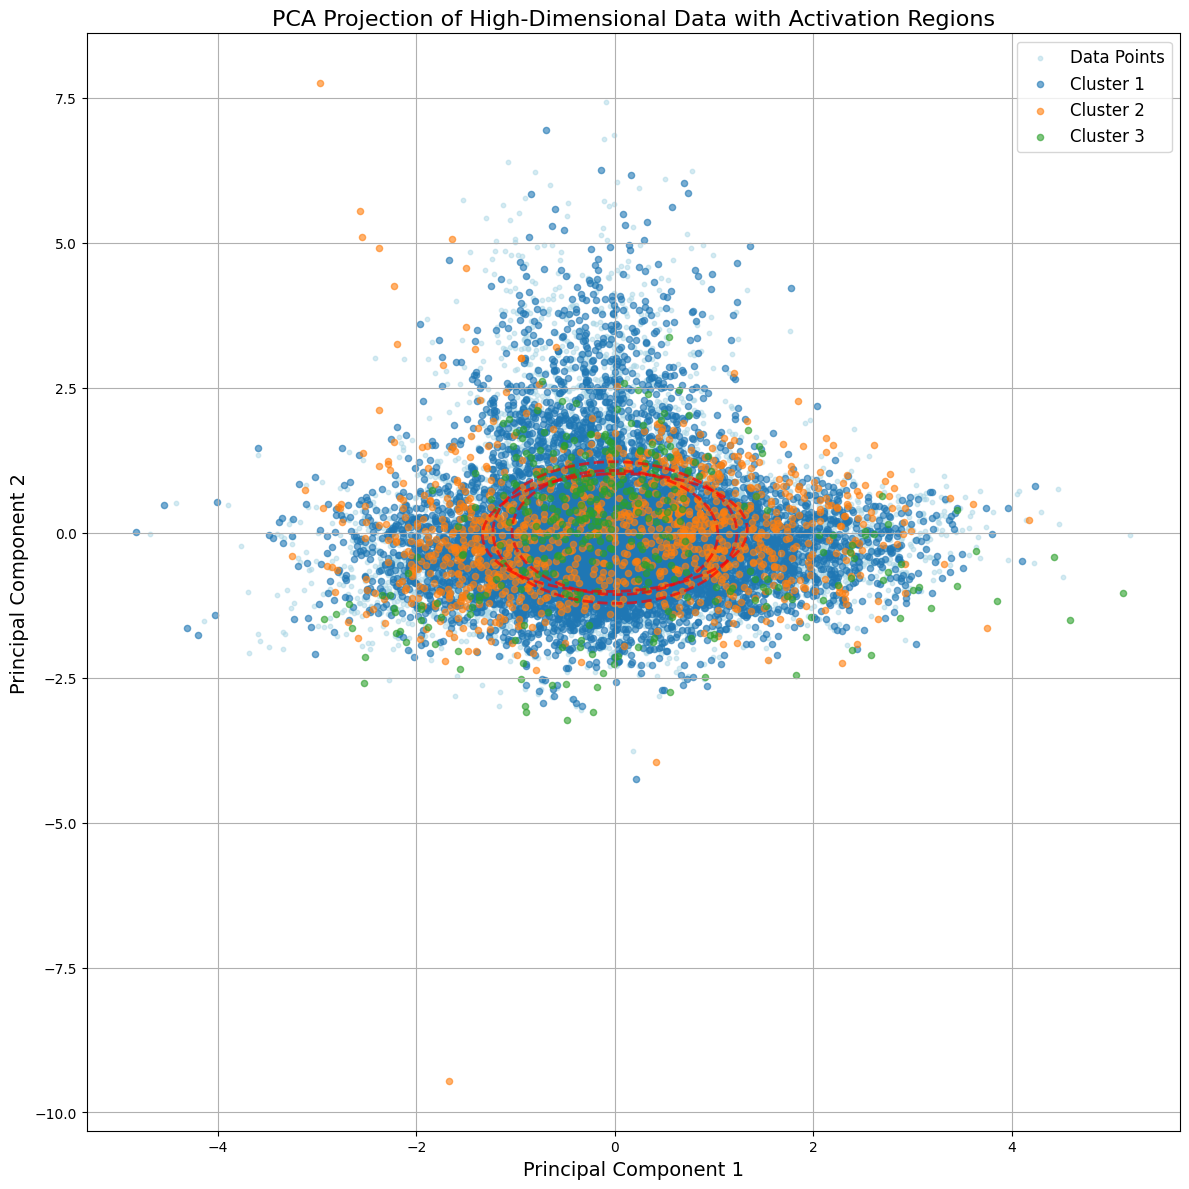


Final Result:
PCA projection of high-dimensional data with activation regions has been saved as 'high_dim_projection.png'.


In [17]:
main()